In [38]:
import pandas_datareader as pdr
import datetime
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pandas_ta as ta
import nltk
from xmlrpc.client import Boolean

In [39]:
def macd_strategy(symbol, start, end):
    """ Backtesting simulation of macd strategy
    Parameters:
    symbol (str): symbol of a stock
    start (datetime): starting date of the backtest
    end (datetime): last date of the backtest

    Returns:
    Dataframe that includes the total amound of asset when using the strategy and drawdown of the strategy. 
    """
    #get data
    price = pdr.get_data_yahoo(symbol, start, end)
    price = price.drop(['Volume', 'Adj Close'], 1)

    #macd calculations
    exp1 = price.Close.ewm(span = 12, adjust=False).mean()
    exp2 = price.Close.ewm(span = 26, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span = 9, adjust=False).mean()

    #add column for entries
    price['Long'] = macd > signal
    # profit calculation for MACD
    money = 10000
    exchange = 0
    wins= 0
    asset = [10000]
    numb=0
    drawdowns = [0]
    difference = []
    for i in range(1, len(price)):
        
        if price['Long'][i] == True:
            #buys if macd is above signal and not bought yet
            if numb==0:
                buy = price['Close'][i]
                numb = money//buy
                money-=numb*buy
            # continue if already bought
            else:
                asset.append(money + (price['Close'][i]*numb))
                drawdowns.append(((money + (price['Close'][i]*numb))-max(asset))/max(asset))
                continue
        else:
            #sell if macd is bellow signal line and didn't sell the stocks yet
            if numb!=0 : 
                sell = price['Close'][i]
                money += (sell)*numb
                exchange +=1
                if sell>buy:
                    wins +=1
                difference.append(sell-buy)
                numb=0
            else: 
                #continue if already sold
                asset.append(money + (price['Close'][i]*numb))
                drawdowns.append(((money + (price['Close'][i]*numb))-max(asset))/max(asset))
                continue
        
        asset.append(money + (price['Close'][i]*numb))
        drawdowns.append(((money + (price['Close'][i]*numb))-max(asset))/max(asset))
    price['MACD']=asset
    price['DD']=drawdowns

    STARTING_BALANCE = 10000
    #daily return
    price['Return'] = price.Close / price.Close.shift(1)
    price.Return.iat[0] = 1
    price['Bench_Bal'] = STARTING_BALANCE * price.Return.cumprod()
    #calculate drawdown
    price['Bench_Peak'] = price.Bench_Bal.cummax()
    price['Bench_DD'] = price.Bench_Bal - price.Bench_Peak

    bench_dd = round((price.Bench_DD / price.Bench_Peak).min() * 100, 2)
    #print("win rate:", wins/exchange)
    print("strategy maximum drawdown", min(price['DD']))
    print("benchmarck maximum drawdwon", bench_dd)
    return price
    
    

In [40]:

def rsi_strategy(symbol, start, end):
    """ Backtesting simulation of rsi strategy
    Parameters:
    symbol (str): symbol of a stock
    start (datetime): starting date of the backtest
    end (datetime): last date of the backtest

    Returns:
    Dataframe that includes the total amound of asset when using the strategy and drawdown of the strategy. 
    """
    #get data
    price = pdr.get_data_yahoo(symbol, start, end)
    price = price.drop(['Volume', 'Adj Close'], 1)
    rsi = price.ta.rsi(close='Close', length=14, append=True, signal_indicators = True, xa=70, xb=30)
    RSIs=[]
    for i in price['RSI_14_B_30']:
        RSIs.append(Boolean(i))
    RSI= pd.Series(RSIs)
    # profit calculation for RSI
    money = 10000
    exchange = 0
    wins= 0
    drawdowns = [0]
    asset = [10000]
    numb=0
    rsi_index = []
    for i in range(1, len(price)):
        if price['RSI_14_B_30'][i]==1 and numb==0:
            rsi_index.append(i)
            buy = price['Close'][i]
            numb = money//buy
            money-=numb*buy
            asset.append(money + (price['Close'][i]*numb))
            drawdowns.append(((money + (price['Close'][i]*numb))-max(asset))/max(asset))
            continue

        if price['RSI_14_A_70'][i]==1 and numb !=0:
            sell = price['Close'][i]
            money += (sell)*numb
            exchange +=1
            if sell>buy:
                wins +=1
            numb=0
            asset.append(money + (price['Close'][i]*numb))
            drawdowns.append(((money + (price['Close'][i]*numb))-max(asset))/max(asset))
            continue
            
        asset.append(money + (price['Close'][i]*numb))
        drawdowns.append(((money + (price['Close'][i]*numb))-max(asset))/max(asset))

        
    price['RSI_strategy'] = asset
    price['DD']=drawdowns
    print("strategy maximum drawdown", min(price['DD']))
    return price



In [41]:


def bollinger_band_strategy(symbol, start, end):
    """ Backtesting simulation of bollinger strategy
    Parameters:
    symbol (str): symbol of a stock
    start (datetime): starting date of the backtest
    end (datetime): last date of the backtest

    Returns:
    Dataframe that includes the total amound of asset when using the strategy and drawdown of the strategy. 
    """
    def get_sma(prices, rate):
        return prices.rolling(rate).mean()
    price = pdr.DataReader(symbol, 'yahoo', start, end)
    closing_prices = price['Close'] 
    ma = get_sma(closing_prices, 20)
    def get_bollinger_bands(prices, rate=20):
        sma = get_sma(prices, rate)
        std = prices.rolling(rate).std()
        bollinger_up = sma + std * 2 # Calculate top band
        bollinger_down = sma - std * 2 # Calculate bottom band
        return bollinger_up, bollinger_down

    bollinger_up, bollinger_down = get_bollinger_bands(closing_prices)

    # backtrading for bollinger bands
    money = 10000
    exchange = 0
    wins= 0
    asset = [10000]
    numb=0
    bollinger_up, bollinger_down = get_bollinger_bands(price['Close'])

    for i in range(1, len(price)):
        if bollinger_down[i]:
            if price['Close'][i] < bollinger_down[i] and numb==0:
                buy = price['Close'][i]
                numb = money//buy
                money-=numb*buy
            elif price['Close'][i] > bollinger_up[i] and numb!=0:
                sell = price['Close'][i]
                money += (sell)*numb
                exchange +=1
                if sell>buy:
                    wins +=1
                numb=0
            else:
                asset.append(money + (price['Close'][i]*numb))
                continue
        else:
            asset.append(money + (price['Close'][i]*numb))
            continue
        asset.append(money + (price['Close'][i]*numb))

    price['Bollinger'] = asset
    return price



In [42]:
# profit calculation for volatility breakout strategy
def breakout_strategy(symbol, start, end,k):
    """ Backtesting simulation of vollatility breakout strategy
    Parameters:
    symbol (str): symbol of a stock
    start (datetime): starting date of the backtest
    end (datetime): last date of the backtest
    k (float): k is a number between 0 and 1. The strategy will buy when today's price increases by (yesterday's vollatility) * k

    Returns:
    Dataframe that includes the total amound of asset when using the strategy and drawdown of the strategy. 
    """
    price = pdr.get_data_yahoo(symbol, start, end)
    price = price.drop(['Volume', 'Adj Close'], 1)
    money = 10000
    exchange = 0
    wins= 0
    asset = [10000]
    numb=0
    profit=0
    for i in range( len(price)-1):
        volatility = abs(price['High'][i-1]-price['Low'][i-1])
        k=0.3
        if price['High'][i]>price['Open'][i]+(volatility*k):
            buy = price['Open'][i]+(volatility*k)
            numb = money//buy
            sell = price['Close'][i]
            profit = (sell-buy)*numb
            exchange +=1
            if sell>buy:
                wins +=1

        numb=0
        money +=profit
        
        profit=0
        asset.append(money)
    price['breakout'] = asset
    return price



In [43]:
def MACD_BREAKOUT_STRATEGY(symbol, start, end, k):
    """ Backtesting simulation of macd and breakout combined strategy
    Parameters:
    symbol (str): symbol of a stock
    start (datetime): starting date of the backtest
    end (datetime): last date of the backtest
    k (float): k is a number between 0 and 1. The strategy will buy when today's price increases by (yesterday's vollatility) * k

    Returns:
    Dataframe that includes the total amound of asset when using the strategy and drawdown of the strategy. 
    """
    
    #get data
    price = pdr.get_data_yahoo(symbol, start, end)
    price = price.drop(['Volume', 'Adj Close'], 1)

    #macd calculations
    exp1 = price.Close.ewm(span = 12, adjust=False).mean()
    exp2 = price.Close.ewm(span = 26, adjust=False).mean()
    exp3 = price.Close.ewm(span = 26, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span = 9, adjust=False).mean()

    #add column for entries
    price['Long'] = macd > signal
    price['200ema']=exp3
    # profit calculation for MACD
    money = 10000
    exchange = 0
    wins= 0
    asset = [10000]
    numb=0
    difference = []
    for i in range(1, len(price)):
        
        if price['Long'][i] == True:
            
            if numb==0:
                buy = price['Close'][i]
                numb = money//buy
                money-=numb*buy
            else:
                asset.append(money + (price['Close'][i]*numb))
                continue
        if price['High'][i]>price['Open'][i]+(price['High'][i-1]-price['Low'][i-1] )*k :
            if numb==0:
                buy = price['Open'][i]+(price['High'][i-1]-price['Low'][i-1] )*k
                numb = money//buy
                money-=numb*buy
            else:
                asset.append(money + (price['Close'][i]*numb))
                continue
        else:
           
            if numb!=0 : 
                sell = price['Close'][i]
                money += (sell)*numb
                exchange +=1
                if sell>buy:
                    wins +=1
                difference.append(sell-buy)
                numb=0
            else: 
                
                asset.append(money + (price['Close'][i]*numb))
                continue
        asset.append(money + (price['Close'][i]*numb))
    price['MACD']=asset
    return price

In [44]:
# here! we combine all the results
start =datetime.datetime(2021, 1, 1)
end= datetime.datetime(2022, 10, 12)
#symbol = 'AAPL'

import random
# symbols of s&p500 companies
df = pd.read_csv('constituents_csv.csv')
random_number = random.randint(1,500)
# selects a random symbol
symbol = df['Symbol'][random_number]

from datetime import date, timedelta

# initializing dates ranges 
test_date1, test_date2 = date(2011, 1, 1), date(2020, 10, 1)
  

  
# getting days between dates
dates_bet = test_date2 - test_date1
total_days = dates_bet.days
  
random.seed(a=None)
randay = random.randrange(total_days)
start = test_date1 + timedelta(days=randay)
end = start.replace(start.year + 2)
# printing dates 
print("The testing range : " + str(test_date1) + " " + str(test_date2))

price = pdr.get_data_yahoo(symbol, start, end)
result_macd= macd_strategy(symbol, start, end)
result_rsi = rsi_strategy(symbol, start, end)
result_bollinger = bollinger_band_strategy(symbol, start,end)
result_breakout = breakout_strategy(symbol, start, end,0.5)
result = MACD_BREAKOUT_STRATEGY(symbol, start, end, 0.3)
print(symbol)
#result_macd_breakout = macd_breakout_strategy(symbol, start, end, 0.3)

The testing range : 2011-01-01 2020-10-01


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.1660089527130127
benchmarck maximum drawdwon -10.51
strategy maximum drawdown -0.024962744876487808


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


D


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


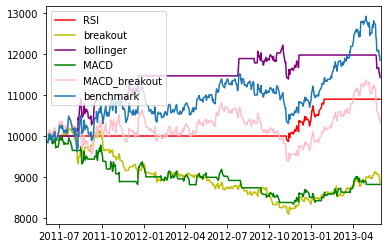

In [45]:
#visualize
plt.plot(result_rsi['RSI_strategy'],c='r', label="RSI")
plt.plot(result_breakout['breakout'],c='y', label = "breakout")
plt.plot(result_bollinger['Bollinger'], c = 'purple', label = "bollinger")
plt.plot(result_macd['MACD'],c='g', label = 'MACD')
plt.plot(result['MACD'], c='pink', label = 'MACD_breakout')
plt.plot(result_rsi['Close']*(10000/result_rsi['Close'][0]), label = "benchmark")
plt.xlim(start,end)
plt.legend()
plt.show()

In [46]:
import random
from datetime import date, timedelta
df = pd.read_csv('constituents_csv.csv')
test_date1, test_date2 = date(2012, 1, 1), date(2021, 1, 1)


# records cumulative profit results of the strategies and benchmark
cum_benchmark = []
cum_macd = []
cum_rsi = []
cum_bollinger = []
cum_breakout = []
cum_macd_breakout =[]

# records cumulative profit when the price went down from the beginning.
cum_benchmark_L = []
cum_macd_L = []
cum_rsi_L = []
cum_bollinger_L = []
cum_breakout_L = []
cum_macd_breakout_L =[]

# records cumulative profit when the price went up from the beginning.
cum_benchmark_W = []
cum_macd_W = []
cum_rsi_W = []
cum_bollinger_W = []
cum_breakout_W = []
cum_macd_breakout_W =[]


for i in range(50):
    #randmly select symbol from s&p500
    random_number = random.randint(1,500)
    symbol = df['Symbol'][random_number]
    
    # getting days between dates
    dates_bet = test_date2 - test_date1
    total_days = dates_bet.days
    random.seed(a=None)
    randay = random.randrange(total_days)
    start = test_date1 + timedelta(days=randay)
    end = start.replace(start.year + 2)
    try:
        print("Testing in date range : " + str(start) + " " + str(end) +"for " + str(symbol))
        price = pdr.get_data_yahoo(symbol, start, end)
        result_macd= macd_strategy(symbol, start, end)
        result_rsi = rsi_strategy(symbol, start, end)
        result_bollinger = bollinger_band_strategy(symbol, start,end)
        result_breakout = breakout_strategy(symbol, start, end,0.5)
        result = MACD_BREAKOUT_STRATEGY(symbol, start, end, 0.5)
        cum_benchmark.append(((result_rsi['Close'][-1]/result_rsi['Close'][0]))*100)
        cum_macd.append((result_macd['MACD'][-1]/10000)*100)
        cum_rsi.append((result_rsi['RSI_strategy'][-1]/10000)*100)
        cum_bollinger.append((result_bollinger['Bollinger'][-1]/10000)*100)
        cum_breakout.append((result_breakout['breakout'][-1]/10000)*100)
        cum_macd_breakout.append((result['MACD'][-1]/10000)*100)

        if (result_rsi['Close'][-1]/result_rsi['Close'][0])>1:
            cum_benchmark_W.append(((result_rsi['Close'][-1]/result_rsi['Close'][0]))*100)
            cum_macd_W.append((result_macd['MACD'][-1]/10000)*100)
            cum_rsi_W.append((result_rsi['RSI_strategy'][-1]/10000)*100)
            cum_bollinger_W.append((result_bollinger['Bollinger'][-1]/10000)*100)
            cum_breakout_W.append((result_breakout['breakout'][-1]/10000)*100)
            cum_macd_breakout_W.append((result['MACD'][-1]/10000)*100)
        else: 
            cum_benchmark_L.append(((result_rsi['Close'][-1]/result_rsi['Close'][0]))*100)
            cum_macd_L.append((result_macd['MACD'][-1]/10000)*100)
            cum_rsi_L.append((result_rsi['RSI_strategy'][-1]/10000)*100)
            cum_bollinger_L.append((result_bollinger['Bollinger'][-1]/10000)*100)
            cum_breakout_L.append((result_breakout['breakout'][-1]/10000)*100)
            cum_macd_breakout_L.append((result['MACD'][-1]/10000)*100)
    except:
        print("data not existing")
cumulative = (sum(cum_benchmark)/len(cum_benchmark),sum(cum_macd)/len(cum_macd),sum(cum_rsi)/len(cum_rsi),sum(cum_bollinger)/len(cum_bollinger),sum(cum_breakout)/len(cum_breakout),sum(cum_macd_breakout)/len(cum_macd_breakout))
cumulative_W = (sum(cum_benchmark_W)/len(cum_benchmark_W),sum(cum_macd_W)/len(cum_macd_W),sum(cum_rsi_W)/len(cum_rsi_W),sum(cum_bollinger_W)/len(cum_bollinger_W),sum(cum_breakout_W)/len(cum_breakout_W),sum(cum_macd_breakout_W)/len(cum_macd_breakout_W))
cumulative_L = (sum(cum_benchmark_L)/len(cum_benchmark_L),sum(cum_macd_L)/len(cum_macd_L),sum(cum_rsi_L)/len(cum_rsi_L),sum(cum_bollinger_L)/len(cum_bollinger_L),sum(cum_breakout_L)/len(cum_breakout_L),sum(cum_macd_breakout_L)/len(cum_macd_breakout_L))
print(cumulative_W)

Testing in date range : 2014-01-18 2016-01-18for FLIR
data not existing
Testing in date range : 2018-11-09 2020-11-09for ALGN


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.3699927505020032
benchmarck maximum drawdwon -58.4
strategy maximum drawdown -0.40666827743938905


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2017-11-20 2019-11-20for MCK


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.3182399432001978
benchmarck maximum drawdwon -38.76
strategy maximum drawdown -0.21712510405415897


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2019-07-12 2021-07-12for VRSN


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.2089868479689593
benchmarck maximum drawdwon -31.61
strategy maximum drawdown -0.16248909867311553


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2014-10-19 2016-10-19for MRK


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.17946179771852003
benchmarck maximum drawdwon -23.18
strategy maximum drawdown -0.2038445164542389


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2015-12-31 2017-12-31for BBT
data not existing
Testing in date range : 2013-06-21 2015-06-21for DISH


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.16969543876902907
benchmarck maximum drawdwon -16.99
strategy maximum drawdown -0.03788945356788153


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2013-07-29 2015-07-29for PGR


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.10383778080556551
benchmarck maximum drawdwon -19.72
strategy maximum drawdown -0.08907998672421617


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2013-10-09 2015-10-09for NLSN
data not existing
Testing in date range : 2013-01-18 2015-01-18for PBCT
data not existing
Testing in date range : 2013-04-17 2015-04-17for SPG


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.10147746087046924
benchmarck maximum drawdwon -20.96
strategy maximum drawdown -0.15199938385300982


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2019-10-16 2021-10-16for EOG


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.3721864826121013
benchmarck maximum drawdwon -66.67
strategy maximum drawdown -0.6142495169031451


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2020-12-10 2022-12-10for ABBV


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.19840129238219495
benchmarck maximum drawdwon -23.29
strategy maximum drawdown -0.12834939366031314


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2018-01-08 2020-01-08for LNC


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.38180231877120824
benchmarck maximum drawdwon -43.21
strategy maximum drawdown -0.37909850826152686


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2013-11-27 2015-11-27for DLR


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.1375945952928553
benchmarck maximum drawdwon -17.3
strategy maximum drawdown -0.05366179602572313


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2015-04-27 2017-04-27for ICE


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.1986225288998614
benchmarck maximum drawdwon -13.85
strategy maximum drawdown -0.08877949225925388


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2015-03-08 2017-03-08for PAYX


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.16010963143114376
benchmarck maximum drawdwon -16.85
strategy maximum drawdown -0.04216070153542058


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2012-08-04 2014-08-04for MAA


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.09246800518502221
benchmarck maximum drawdwon -19.77
strategy maximum drawdown -0.14017050242484913


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2020-03-21 2022-03-21for MRK


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.09852551319727086
benchmarck maximum drawdwon -20.17
strategy maximum drawdown -0.1508488909700684


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2017-12-18 2019-12-18for VRTX


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.28257934115300665
benchmarck maximum drawdwon -21.18
strategy maximum drawdown -0.1074828658400302


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2015-08-09 2017-08-09for MMC


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.13376960551726957
benchmarck maximum drawdwon -12.44
strategy maximum drawdown -0.10488657602286258


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2013-07-21 2015-07-21for NUE


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.22249636022815328
benchmarck maximum drawdwon -27.39
strategy maximum drawdown -0.2346528619258567


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2018-10-08 2020-10-08for BBY


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.2710062562414411
benchmarck maximum drawdwon -44.86
strategy maximum drawdown -0.36895088005456284


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2015-02-05 2017-02-05for CCL


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.20589579573462172
benchmarck maximum drawdwon -23.98
strategy maximum drawdown -0.23961593592191024


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2017-02-04 2019-02-04for ABT


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.20505725860368915
benchmarck maximum drawdwon -11.73
strategy maximum drawdown -0.0379930508021654


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2017-10-07 2019-10-07for ADSK


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.1864168084042326
benchmarck maximum drawdwon -24.73
strategy maximum drawdown -0.20019162539543436


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2020-10-23 2022-10-23for GE


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.4698751569859178
benchmarck maximum drawdwon -46.79
strategy maximum drawdown -0.4504510754343404


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2017-03-17 2019-03-17for VFC


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.19362424295170177
benchmarck maximum drawdwon -30.09
strategy maximum drawdown -0.2485940521515152


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2019-09-16 2021-09-16for ACN


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.15862881476891064
benchmarck maximum drawdwon -33.45
strategy maximum drawdown -0.26807515346431093


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2012-05-11 2014-05-11for KEY


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.1327315917848511
benchmarck maximum drawdwon -12.94
strategy maximum drawdown -0.035


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2018-10-11 2020-10-11for D


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.18085879000398822
benchmarck maximum drawdwon -33.86
strategy maximum drawdown -0.33083991286635117


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2015-05-10 2017-05-10for IVZ


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.23629999146393707
benchmarck maximum drawdwon -43.9
strategy maximum drawdown -0.4138905059505353


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2017-09-18 2019-09-18for LYB


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.18007604082771783
benchmarck maximum drawdwon -43.18
strategy maximum drawdown -0.346426339817173


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2018-12-31 2020-12-31for AEE


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.1847848754864612
benchmarck maximum drawdwon -29.52
strategy maximum drawdown -0.20932428273367096


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2018-03-23 2020-03-23for DUK


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.14153619656101218
benchmarck maximum drawdwon -37.37
strategy maximum drawdown -0.25266376454721795


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2020-11-28 2022-11-28for STI
data not existing
Testing in date range : 2015-08-15 2017-08-15for O


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.17643915814773864
benchmarck maximum drawdwon -26.24
strategy maximum drawdown -0.09690686561036599


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2016-10-17 2018-10-17for GT


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.2440796253493013
benchmarck maximum drawdwon -44.41
strategy maximum drawdown -0.31856883287797483


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2020-09-14 2022-09-14for DOV


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.14330869325640186
benchmarck maximum drawdwon -35.88
strategy maximum drawdown -0.3580075729585161


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2012-08-01 2014-08-01for LUK
data not existing
Testing in date range : 2014-04-22 2016-04-22for SNA


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.14906603767973026
benchmarck maximum drawdwon -22.22
strategy maximum drawdown -0.22155212798644577


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2018-11-21 2020-11-21for BEN


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.30161110494677806
benchmarck maximum drawdwon -57.11
strategy maximum drawdown -0.5133777275112547


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2012-05-18 2014-05-18for UNP


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.1517689990422137
benchmarck maximum drawdwon -8.54
strategy maximum drawdown 0.0


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2019-06-30 2021-06-30for GPC


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.18446926353600804
benchmarck maximum drawdwon -53.32
strategy maximum drawdown -0.5063842621997361


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2015-06-20 2017-06-20for RSG


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.07355889208887209
benchmarck maximum drawdwon -8.85
strategy maximum drawdown -0.06736973998295566


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2020-10-01 2022-10-01for OXY


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.18860602724523806
benchmarck maximum drawdwon -33.3
strategy maximum drawdown -0.0877698740179636


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2019-08-07 2021-08-07for SLG


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.4573058709462004
benchmarck maximum drawdwon -61.54
strategy maximum drawdown -0.5678734760284424


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2018-10-09 2020-10-09for GOOGL


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.13346168212890624
benchmarck maximum drawdwon -30.87
strategy maximum drawdown -0.23931338575687253


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2020-09-08 2022-09-08for IBM


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.17389494039973888
benchmarck maximum drawdwon -19.93
strategy maximum drawdown -0.09874089842124713


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2018-04-11 2020-04-11for CLX


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.3834758319526066
benchmarck maximum drawdwon -16.28
strategy maximum drawdown -0.08992946971829284


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/3614453843.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


(149.59805397079057, 125.35549118492334, 120.67931469864314, 121.47010288582906, 109.07109214180048, 123.09083050462937)


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/954202551.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


<BarContainer object of 6 artists>

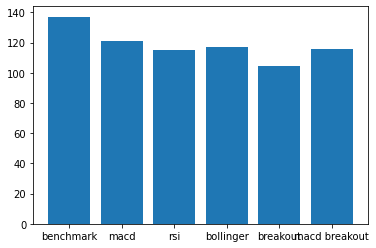

In [47]:
plt.bar(['benchmark','macd','rsi','bollinger','breakout','macd breakout'],cumulative)

In [48]:
import random
df = pd.read_csv('constituents_csv.csv')
random_number = random.randint(1,500)
symbol = df['Symbol'][random_number]

from datetime import date, timedelta

# initializing dates ranges 
test_date1, test_date2 = date(2011, 1, 1), date(2020, 10, 1)
  

# getting days between dates
dates_bet = test_date2 - test_date1
total_days = dates_bet.days
  
random.seed(a=None)
randay = random.randrange(total_days)
start = test_date1 + timedelta(days=randay)
end = start.replace(start.year + 2)
# printing dates 
print("The testing range : " + str(start) + " " + str(end))





def bullish_bearish(arr, price, k):

	""" Finds bullish and bearish periods with O(n) complexity
	Parameters:
	arr (arr): An array of daily price changes in percentage. (today's closing price - yesterday's closing price)
	price (dataframe): pandas dataframe that include closing price of a stock
	k (int): length of a period in days. If k=30, then we find bullish period that's a month long

	Returns:
	bullsih (arr): A list of index where the next 30 days price change meets the bullish market conditions
	bearish (arr): A list of index where the next 30 days price change meets the bearish market conditions
	"""
	# length of the array
	n = len(arr)

	# n must be greater than k
	if n < k:
		print("Invalid")
		return -1

	# Compute sum of first window of size k
	window_sum = sum(arr[:k])

	# first sum available 
	max_sum = window_sum
	bullish = []
	bearish = []
	# Compute the sums of remaining windows by
	# removing first element of previous
	# window and adding last element of
	# the current window.
	for i in range(n - k):
		window_sum = window_sum - arr[i] + arr[i + k]
		count = sum(map(lambda x : x>0, arr[i:i+k]))

		# if more than 2/3 of the days in the period were positive and the end of the period incrased by more than 10% of the start of the period
		if count>2*k/3 and (price[i+k]-price[i])/price[i]>0.1:
			bullish.append(i)

		# if more than 2/3 of the days in the period were negative and the end of the period decreased by more than 10% of the start of the period
		if count <k/3 and price[i+k]/price[i]<0.9:
			bearish.append(i)
		max_sum = max(window_sum, max_sum)
	return bullish, bearish


price = pdr.get_data_yahoo(symbol, start, end)
price_change = []
for i in range(1, len(price)):
	price_change.append(((price['Close'][i]-price['Close'][i-1])/price['Close'][i-1])*100)
k=30
bullish_periods = (bullish_bearish(price_change,price['Close'][1:], k))[0]
bearish_periods = (bullish_bearish(price_change,price['Close'][1:], k))[1]
print(bearish_periods)

start_index = [bullish_periods[0]]
end_index = []
for i in range(1,len(bullish_periods)-1):
    if start_index[-1]+k<bullish_periods[i]:
        end_index.append(start_index[-1]+k)
        start_index.append(bullish_periods[i])

end_index.append(start_index[-1]+k)
print(start_index, end_index) 


The testing range : 2020-06-25 2022-06-25


RemoteDataError: No data fetched for symbol FLIR using YahooDailyReader

/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_32249/2901325613.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.025163808661231513
benchmarck maximum drawdwon -2.52
strategy maximum drawdown 0.0


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_32249/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


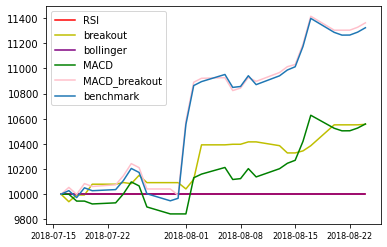

strategy maximum drawdown -0.04241775203202645
benchmarck maximum drawdwon -4.25
strategy maximum drawdown 0.0


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_32249/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


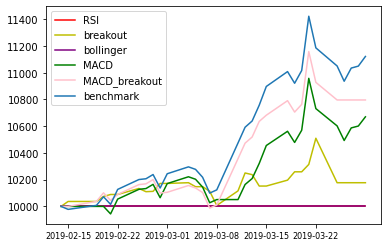

strategy maximum drawdown -0.02498452207338042
benchmarck maximum drawdwon -2.51
strategy maximum drawdown 0.0


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_32249/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


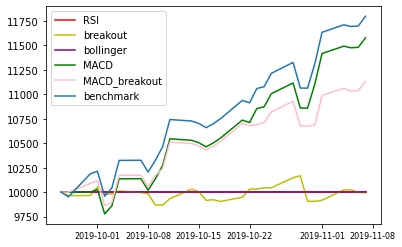

strategy maximum drawdown -0.02744664306640625
benchmarck maximum drawdwon -3.13
strategy maximum drawdown 0.0


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_32249/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


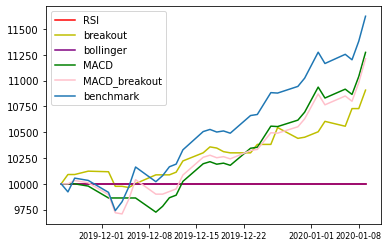

[11322.612724092229, 11121.19400200955, 11798.17151284208, 11624.057159538299] [10558.127456665039, 10669.840454101562, 11577.969619750977, 11273.77075958252] [10000.0, 10000.0, 10000.0, 10000.0] [10000.0, 10000.0, 10000.0, 10000.0] [10555.306267547607, 10177.066638183594, 9993.85359191895, 10908.005282592769] [11361.530002593996, 10795.965207290648, 11130.898647689823, 11212.289100646973]


<BarContainer object of 6 artists>

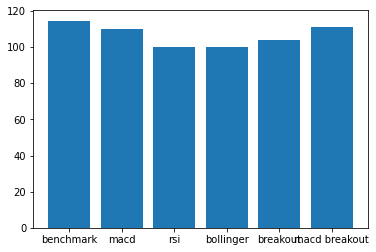

In [ ]:
# records the profit of the strategies in a bullish market
bullish_macd = []
bullish_benchmark = []
bullish_rsi = []
bullish_bollinger = []
bullish_breakout = []
bullish_macd_breakout = []

for i in range(len(start_index)):
    new_start = price[start_index[i]:end_index[i]].index[0]
    new_end = price[start_index[i]:end_index[i]].index[-1]

    result_macd= macd_strategy(symbol, new_start, new_end)
    result_rsi = rsi_strategy(symbol, new_start, new_end)
    result_bollinger = bollinger_band_strategy(symbol, new_start,new_end)
    result_breakout = breakout_strategy(symbol, new_start, new_end,0.5)
    result = MACD_BREAKOUT_STRATEGY(symbol, new_start, new_end, 0.3)
    bullish_macd.append(result_macd['MACD'][-1])
    bullish_benchmark.append(result_rsi['Close'][-1]*10000/result_rsi['Close'][0])
    bullish_rsi.append(result_rsi['RSI_strategy'][-1])
    bullish_bollinger.append(result_bollinger['Bollinger'][-1])
    bullish_breakout.append(result_breakout['breakout'][-1])
    bullish_macd_breakout.append(result['MACD'][-1])

    plt.plot(result_rsi['RSI_strategy'],c='r', label="RSI")
    plt.plot(result_breakout['breakout'],c='y', label = "breakout")
    plt.plot(result_bollinger['Bollinger'], c = 'purple', label = "bollinger")
    plt.plot(result_macd['MACD'],c='g', label = 'MACD')
    plt.plot(result['MACD'], c='pink', label = 'MACD_breakout')
    plt.plot(result_rsi['Close']*(10000/result_rsi['Close'][0]), label = "benchmark")
    # plt.xlim(new_start,new_end)
    plt.legend()
    plt.xticks(fontsize=8)
    plt.show()
print(bullish_benchmark, bullish_macd,bullish_rsi, bullish_bollinger,bullish_breakout,bullish_macd_breakout)
cumulative_profit = (sum(bullish_benchmark)/len(bullish_benchmark)/100, sum(bullish_macd)/len(bullish_macd)/100,sum(bullish_rsi)/len(bullish_rsi)/100, sum(bullish_bollinger)/len(bullish_bollinger)/100,sum(bullish_breakout)/(len(bullish_breakout))/100,sum(bullish_macd_breakout)/len(bullish_breakout)/100)
plt.bar(['benchmark','macd','rsi','bollinger','breakout','macd breakout'],cumulative_profit)

In [49]:
start_index = [bearish_periods[0]]
end_index = []
for i in range(1,len(bearish_periods)):
    if start_index[-1]+k<bearish_periods[i]:
        end_index.append(start_index[-1]+k)
        start_index.append(bearish_periods[i])

end_index.append(start_index[-1]+k)
print(start_index, end_index) 

NameError: name 'bearish_periods' is not defined

In [50]:
# compares the profits of the strategies in a bearish market
bearish_macd = []
bearish_benchmark = []
bearish_rsi = []
bearish_bollinger = []
bearish_breakout = []
bearish_macd_breakout = []

for i in range(len(start_index)):
    new_start = price[start_index[i]:end_index[i]].index[0]
    new_end = price[start_index[i]:end_index[i]].index[-1]

    result_macd= macd_strategy(symbol, new_start, new_end)
    result_rsi = rsi_strategy(symbol, new_start, new_end)
    result_bollinger = bollinger_band_strategy(symbol, new_start,new_end)
    result_breakout = breakout_strategy(symbol, new_start, new_end,0.5)
    result = MACD_BREAKOUT_STRATEGY(symbol, new_start, new_end, 0.3)
    bearish_macd.append(result_macd['MACD'][-1])
    bearish_benchmark.append(result_rsi['Close'][-1]*10000/result_rsi['Close'][0])
    bearish_rsi.append(result_rsi['RSI_strategy'][-1])
    bearish_bollinger.append(result_bollinger['Bollinger'][-1])
    bearish_breakout.append(result_breakout['breakout'][-1])
    bearish_macd_breakout.append(result['MACD'][-1])
    
    

    plt.plot(result_rsi['RSI_strategy'],c='r', label="RSI")
    plt.plot(result_breakout['breakout'],c='y', label = "breakout")
    plt.plot(result_bollinger['Bollinger'], c = 'purple', label = "bollinger")
    plt.plot(result_macd['MACD'],c='g', label = 'MACD')
    plt.plot(result['MACD'], c='pink', label = 'MACD_breakout')
    plt.plot(result_rsi['Close']*(10000/result_rsi['Close'][0]), label = "benchmark")
    # plt.xlim(new_start,new_end)
    plt.legend()
    plt.xticks(fontsize=8)
    plt.show()
print(bearish_benchmark, bearish_macd,bearish_rsi, bearish_bollinger,bearish_breakout,bearish_macd_breakout)
cumulative_profit = (sum(bearish_benchmark)/len(bearish_benchmark)/100, sum(bearish_macd)/len(bearish_macd)/100,sum(bearish_rsi)/len(bearish_rsi)/100, sum(bearish_bollinger)/len(bearish_bollinger)/100,sum(bearish_breakout)/(len(bearish_breakout))/100,sum(bearish_macd_breakout)/len(bearish_breakout)/100)
plt.bar(['benchmark','macd','rsi','bollinger','breakout','macd breakout'],cumulative_profit)

NameError: name 'start_index' is not defined

In [321]:
# calculates the p-value
from scipy import stats
ttest,p_value = stats.ttest_ind(bearish_benchmark,bearish_bollinger)
print("p value:%.8f" % p_value)
print("since the hypothesis is one sided >> use p_value/2 >> p_value_one_sided:%.4f" %(p_value/2))
if p_value/2 <0.05:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")

p value:0.01360149
since the hypothesis is one sided >> use p_value/2 >> p_value_one_sided:0.0068
Reject null hypothesis


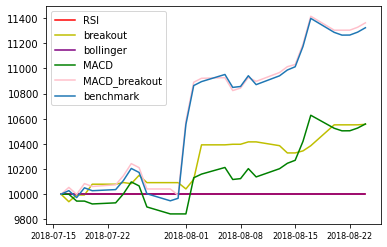

In [184]:
#visualize
plt.plot(result_rsi['RSI_strategy'],c='r', label="RSI")
plt.plot(result_breakout['breakout'],c='y', label = "breakout")
plt.plot(result_bollinger['Bollinger'], c = 'purple', label = "bollinger")
plt.plot(result_macd['MACD'],c='g', label = 'MACD')
plt.plot(result['MACD'], c='pink', label = 'MACD_breakout')
plt.plot(result_rsi['Close']*(10000/result_rsi['Close'][0]), label = "benchmark")
# plt.xlim(new_start,new_end)
plt.legend()
plt.xticks(fontsize=8)
plt.show()

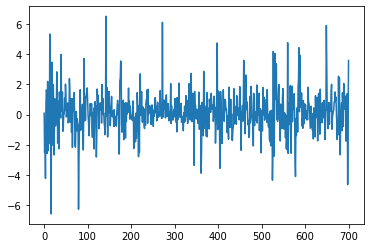

In [117]:
plt.plot(price_change)

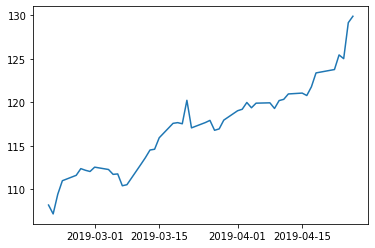

In [68]:
plt.plot(price['Close'][33:81])

In [16]:
import feedparser
from bs4 import BeautifulSoup
import urllib
from dateparser import parse as parse_date
import requests



class GoogleNews:
    def __init__(self, lang = 'en', country = 'US'):
        self.lang = lang.lower()
        self.country = country.upper()
        self.BASE_URL = 'https://news.google.com/rss'

    def __top_news_parser(self, text):
        """Return subarticles from the main and topic feeds"""
        try:
            bs4_html = BeautifulSoup(text, "html.parser")
            # find all li tags
            lis = bs4_html.find_all('li')
            sub_articles = []
            for li in lis:
                try:
                    sub_articles.append({"url": li.a['href'],
                                         "title": li.a.text,
                                         "publisher": li.font.text})
                except:
                    pass
            return sub_articles
        except:
            return text

    def __ceid(self):
        """Compile correct country-lang parameters for Google News RSS URL"""
        return '?ceid={}:{}&hl={}&gl={}'.format(self.country,self.lang,self.lang,self.country)

    def __add_sub_articles(self, entries):
        for i, val in enumerate(entries):
            if 'summary' in entries[i].keys():
                entries[i]['sub_articles'] = self.__top_news_parser(entries[i]['summary'])
            else:
                entries[i]['sub_articles'] = None
        return entries

    def __scaping_bee_request(self, api_key, url):
        response = requests.get(
            url="https://app.scrapingbee.com/api/v1/",
            params={
                "api_key": api_key,
                "url": url,
                "render_js": "false"
            }
        )
        if response.status_code == 200:
            return response
        if response.status_code != 200:
            raise Exception("ScrapingBee status_code: "  + str(response.status_code) + " " + response.text)

    def __parse_feed(self, feed_url, proxies=None, scraping_bee = None):

        if scraping_bee and proxies:
            raise Exception("Pick either ScrapingBee or proxies. Not both!")

        if proxies:
            r = requests.get(feed_url, proxies = proxies)
        else:
            r = requests.get(feed_url)

        if scraping_bee:
            r = self.__scaping_bee_request(url = feed_url, api_key = scraping_bee)
        else:
            r = requests.get(feed_url)


        if 'https://news.google.com/rss/unsupported' in r.url:
            raise Exception('This feed is not available')

        d = feedparser.parse(r.text)

        if not scraping_bee and not proxies and len(d['entries']) == 0:
            d = feedparser.parse(feed_url)

        return dict((k, d[k]) for k in ('feed', 'entries'))

    def __search_helper(self, query):
        return urllib.parse.quote_plus(query)

    def __from_to_helper(self, validate=None):
        try:
            validate = parse_date(validate).strftime('%Y-%m-%d')
            return str(validate)
        except:
            raise Exception('Couldnt parse your date')



    def top_news(self, proxies=None, scraping_bee = None):
        """Return a list of all articles from the main page of Google News
        given a country and a language"""
        d = self.__parse_feed(self.BASE_URL + self.__ceid(), proxies=proxies, scraping_bee=scraping_bee)
        d['entries'] = self.__add_sub_articles(d['entries'])
        return d

    def topic_headlines(self, topic: str, proxies=None, scraping_bee=None):
        """Return a list of all articles from the topic page of Google News
        given a country and a language"""
        #topic = topic.upper()
        if topic.upper() in ['WORLD', 'NATION', 'BUSINESS', 'TECHNOLOGY', 'ENTERTAINMENT', 'SCIENCE', 'SPORTS', 'HEALTH']:
            d = self.__parse_feed(self.BASE_URL + '/headlines/section/topic/{}'.format(topic.upper()) + self.__ceid(), proxies = proxies, scraping_bee=scraping_bee)

        else:
            d = self.__parse_feed(self.BASE_URL + '/topics/{}'.format(topic) + self.__ceid(), proxies = proxies, scraping_bee=scraping_bee)

        d['entries'] = self.__add_sub_articles(d['entries'])
        if len(d['entries']) > 0:
            return d
        else:
            raise Exception('unsupported topic')

    def geo_headlines(self, geo: str, proxies=None, scraping_bee=None):
        """Return a list of all articles about a specific geolocation
        given a country and a language"""
        d = self.__parse_feed(self.BASE_URL + '/headlines/section/geo/{}'.format(geo) + self.__ceid(), proxies = proxies, scraping_bee=scraping_bee)

        d['entries'] = self.__add_sub_articles(d['entries'])
        return d

    def search(self, query: str, helper = True, when = None, from_ = None, to_ = None, proxies=None, scraping_bee=None):
        """
        Return a list of all articles given a full-text search parameter,
        a country and a language

        :param bool helper: When True helps with URL quoting
        :param str when: Sets a time range for the artiles that can be found
        """

        if when:
            query += ' when:' + when

        if from_ and not when:
            #from_ = self.__from_to_helper(validate=from_)
            query += ' after:' + from_

        if to_ and not when:
            #to_ = self.__from_to_helper(validate=to_)
            query += ' before:' + to_

        if helper == True:
            query = self.__search_helper(query)

        search_ceid = self.__ceid()
        search_ceid = search_ceid.replace('?', '&')

        d = self.__parse_feed(self.BASE_URL + '/search?q={}'.format(query) + search_ceid, proxies = proxies, scraping_bee=scraping_bee)

        d['entries'] = self.__add_sub_articles(d['entries'])
        return d

In [17]:
import pandas as pd
import datetime
gn = GoogleNews()
def get_news(search):
    stories = []
    start_date = datetime.date(2022,9,8)
    end_date = datetime.date(2022,9,24)
    delta = datetime.timedelta(days=1)
    date_list = pd.date_range(start_date, end_date).tolist()
    for date in date_list[:-1]:
        result = gn.search(search, from_=date.strftime('%Y-%m-%d'), to_=(date+delta).strftime('%Y-%m-%d'))
        newsitem = result['entries']
        for item in newsitem:
            story = {
                'title':item.title,
            }
            stories.append(story)
    return stories

df = pd.DataFrame(get_news('AAPL'))

In [65]:
df['title'] = df['title'].astype(str).str.lower()
df.head(3)

,title
0,aapl stock will rise as consumers search to pr...
1,aapl stock alert: 13 takeaways from the latest...
2,why apple fell today - the motley fool


In [20]:
from nltk.tokenize import RegexpTokenizer

regexp = RegexpTokenizer('\w+')

df['text_token']=df['title'].apply(regexp.tokenize)
df.head(3)

,title,text_token
0,"southern tire mart, pilot flying j form strate...","[southern, tire, mart, pilot, flying, j, form,..."
1,"purcell tire joins michelin's commercial, retr...","[purcell, tire, joins, michelin, s, commercial..."


In [21]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/haechan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
from nltk.corpus import stopwords

# Make a list of english stopwords
stopwords = nltk.corpus.stopwords.words("english")

# Extend the list with your own custom stopwords
my_stopwords = ['https']
stopwords.extend(my_stopwords)

In [23]:
# Remove stopwords
df['text_token'] = df['text_token'].apply(lambda x: [item for item in x if item not in stopwords])
df.head(3)

,title,text_token
0,"southern tire mart, pilot flying j form strate...","[southern, tire, mart, pilot, flying, j, form,..."
1,"purcell tire joins michelin's commercial, retr...","[purcell, tire, joins, michelin, commercial, r..."


In [24]:

df['text_string'] = df['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))

In [25]:
df[['title', 'text_token', 'text_string']].head()

,title,text_token,text_string
0,"southern tire mart, pilot flying j form strate...","[southern, tire, mart, pilot, flying, j, form,...",southern tire mart pilot flying form strategic...
1,"purcell tire joins michelin's commercial, retr...","[purcell, tire, joins, michelin, commercial, r...",purcell tire joins michelin commercial retread...


In [26]:
all_words = ' '.join([word for word in df['text_string']])
tokenized_words = nltk.tokenize.word_tokenize(all_words)
from nltk.probability import FreqDist

fdist = FreqDist(tokenized_words)
fdist

FreqDist({'tire': 4, 'modern': 2, 'dealer': 2, 'southern': 1, 'mart': 1, 'pilot': 1, 'flying': 1, 'form': 1, 'strategic': 1, 'alliance': 1, ...})

In [27]:
df['text_string_fdist'] = df['text_token'].apply(lambda x: ' '.join([item for item in x if fdist[item] >= 1 ]))

In [28]:
df[['title', 'text_token', 'text_string', 'text_string_fdist']].head()

,title,text_token,text_string,text_string_fdist
0,"southern tire mart, pilot flying j form strate...","[southern, tire, mart, pilot, flying, j, form,...",southern tire mart pilot flying form strategic...,southern tire mart pilot flying form strategic...
1,"purcell tire joins michelin's commercial, retr...","[purcell, tire, joins, michelin, commercial, r...",purcell tire joins michelin commercial retread...,purcell tire joins michelin commercial retread...


In [29]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /Users/haechan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/haechan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [30]:
from nltk.stem import WordNetLemmatizer
wordnet_lem = WordNetLemmatizer()

df['text_string_lem'] = df['text_string'].apply(wordnet_lem.lemmatize)

In [222]:
all_words_lem = ' '.join([word for word in df['text_string_lem']])

In [223]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/haechan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [224]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

words = nltk.word_tokenize(all_words_lem)

In [225]:
# sentiment analysis
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/haechan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [32]:
from nltk.sentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [227]:
# polarity scores
df['polarity'] = df['text_string_lem'].apply(lambda x: analyzer.polarity_scores(x))
df.tail(3)

,title,text_token,text_string,text_string_fdist,text_string_lem,polarity
1150,Why Nio Stock Is Sliding Today - Nasdaq,"[Why, Nio, Stock, Is, Sliding, Today, Nasdaq]",Why Nio Stock Sliding Today Nasdaq,Why Nio Stock Sliding Today Nasdaq,Why Nio Stock Sliding Today Nasdaq,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1151,Daseke Accepts Resignation Of CFO Jason Bates ...,"[Daseke, Accepts, Resignation, Of, CFO, Jason,...",Daseke Accepts Resignation CFO Jason Bates Nasdaq,Daseke Accepts Resignation CFO Jason Bates Nasdaq,Daseke Accepts Resignation CFO Jason Bates Nasdaq,"{'neg': 0.232, 'neu': 0.526, 'pos': 0.242, 'co..."
1152,Why Algonquin Power & Utilities is a Top 10 SA...,"[Why, Algonquin, Power, Utilities, Top, 10, SA...",Why Algonquin Power Utilities Top SAFE Interna...,Why Algonquin Power Utilities Top SAFE Interna...,Why Algonquin Power Utilities Top SAFE Interna...,"{'neg': 0.0, 'neu': 0.624, 'pos': 0.376, 'comp..."


In [228]:
df = pd.concat(
    [df.drop(['polarity'], axis=1), 
     df['polarity'].apply(pd.Series)], axis=1)

In [229]:
df['sentiment'] = df['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')
df['compound'].mean()<0
df['sentiment'].value_counts()['positive']>df['sentiment'].value_counts()['negative']

True

In [270]:
random_number = random.randint(1,500)
df = pd.read_csv('constituents_csv.csv')
symbol = df['Symbol'][random_number]
    # getting days between dates
dates_bet = test_date2 - test_date1
total_days = dates_bet.days
random.seed(a=None)
randay = random.randrange(total_days)
start = test_date1 + timedelta(days=randay)
start.year

2016

In [274]:
df = pd.read_csv('constituents_csv.csv')
df['Symbol']

0       MMM
1       AOS
2       ABT
3      ABBV
4       ACN
       ... 
500     XYL
501     YUM
502     ZBH
503    ZION
504     ZTS
Name: Symbol, Length: 505, dtype: object

In [280]:

from datetime import date, timedelta
symbols = pd.read_csv('constituents_csv.csv')
test_date1, test_date2 = date(2012, 1, 1), date(2021, 1, 1)

cum_benchmark = []
cum_macd = []
cum_rsi = []
cum_bollinger = []
cum_breakout = []
cum_macd_breakout =[]

cum_benchmark_EN = []
cum_macd_EN = []
cum_rsi_EN = []
cum_bollinger_EN = []
cum_breakout_EN = []
cum_macd_breakout_EN =[]

cum_benchmark_N = []
cum_macd_N = []
cum_rsi_N = []
cum_bollinger_N = []
cum_breakout_N = []
cum_macd_breakout_N =[]

cum_benchmark_P = []
cum_macd_P = []
cum_rsi_P = []
cum_bollinger_P = []
cum_breakout_P = []
cum_macd_breakout_P =[]

cum_benchmark_EP = []
cum_macd_EP = []
cum_rsi_EP = []
cum_bollinger_EP = []
cum_breakout_EP = []
cum_macd_breakout_EP=[]


monthly_sentiments=[]

for i in range(1):

    #randmly select symbol from s&p500
    random_number = random.randint(1,500)
    symbol = symbols['Symbol'][random_number]
    # getting days between dates
    dates_bet = test_date2 - test_date1
    total_days = dates_bet.days
    random.seed(a=None)
    randay = random.randrange(total_days)
    start = test_date1 + timedelta(days=randay)
    end = start.replace(start.year + 1)

    for month in range(1,5):
        start = datetime.datetime(start.year, month, 1)
        end= datetime.datetime(start.year,month+1, 1)
        price = pdr.get_data_yahoo('AAPL', start, end)
        gn = GoogleNews()
        
        delta = datetime.timedelta(days=1)
        #date_list = pd.date_range(start, end).tolist()
        date_list = price.index
        daily_sentiments = []
        
        for j in range(len(price)):
            #scraping google news titles
            stories = []
            result = gn.search('AAPL', from_=date_list[j].strftime('%Y-%m-%d'), to_=(date_list[j]+delta).strftime('%Y-%m-%d'))
            newsitem = result['entries']
            for item in newsitem:
                story = {
                    'title':item.title,
                        
                }
                stories.append(story)


            df = pd.DataFrame(stories)
            if df.empty:
                
                daily_sentiments.append(0)
            else:
                #NLP
                df['title'] = df['title'].astype(str).str.lower()
                regexp = RegexpTokenizer('\w+')
                df['text_token']=df['title'].apply(regexp.tokenize)

                #remove stop words
                stopwords = nltk.corpus.stopwords.words("english")
                df['text_token'] = df['text_token'].apply(lambda x: [item for item in x if item not in stopwords])
                #remove words shorter than 2 letters
                df['text_string'] = df['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))
                
                wordnet_lem = WordNetLemmatizer()

                df['text_string_lem'] = df['text_string'].apply(wordnet_lem.lemmatize)
                all_words_lem = ' '.join([word for word in df['text_string_lem']])
                words = nltk.word_tokenize(all_words_lem)
                analyzer = SentimentIntensityAnalyzer()
                df['polarity'] = df['text_string_lem'].apply(lambda x: analyzer.polarity_scores(x))
                df = pd.concat(
                [df.drop(['polarity'], axis=1), df['polarity'].apply(pd.Series)], axis=1)
                df['sentiment'] = df['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')
                sentiment_compound = df['compound'].mean()
                print(df)
                daily_sentiments.append(sentiment_compound)
        monthly_sentiments.append(sum(daily_sentiments)/len(daily_sentiments))

        try:
            print("Testing in date range : " + str(start) + " " + str(end) +"for " + str(symbol))
            price = pdr.get_data_yahoo(symbol, start, end)
            result_macd= macd_strategy(symbol, start, end)
            result_rsi = rsi_strategy(symbol, start, end)
            result_bollinger = bollinger_band_strategy(symbol, start,end)
            result_breakout = breakout_strategy(symbol, start, end,0.5)
            result = MACD_BREAKOUT_STRATEGY(symbol, start, end, 0.5)

            # when the sentiment is extremely negative
            if monthly_sentiments[-1] < 0.01:
                cum_benchmark_EN.append(((result_rsi['Close'][-1]/result_rsi['Close'][0]))*100)
                cum_macd_EN.append((result_macd['MACD'][-1]/10000)*100)
                cum_rsi_EN.append((result_rsi['RSI_strategy'][-1]/10000)*100)
                cum_bollinger_EN.append((result_bollinger['Bollinger'][-1]/10000)*100)
                cum_breakout_EN.append((result_breakout['breakout'][-1]/10000)*100)
                cum_macd_breakout_EN.append((result['MACD'][-1]/10000)*100)
            # when the sentiment is negative
            elif 0.01<=monthly_sentiments[-1] < 0.05:
                cum_benchmark_N.append(((result_rsi['Close'][-1]/result_rsi['Close'][0]))*100)
                cum_macd_N.append((result_macd['MACD'][-1]/10000)*100)
                cum_rsi_N.append((result_rsi['RSI_strategy'][-1]/10000)*100)
                cum_bollinger_N.append((result_bollinger['Bollinger'][-1]/10000)*100)
                cum_breakout_N.append((result_breakout['breakout'][-1]/10000)*100)
                cum_macd_breakout_N.append((result['MACD'][-1]/10000)*100)

            # when the sentiment is neutral
            elif 0.05<=monthly_sentiments[-1] < 0.09:
                cum_benchmark.append(((result_rsi['Close'][-1]/result_rsi['Close'][0]))*100)
                cum_macd.append((result_macd['MACD'][-1]/10000)*100)
                cum_rsi.append((result_rsi['RSI_strategy'][-1]/10000)*100)
                cum_bollinger.append((result_bollinger['Bollinger'][-1]/10000)*100)
                cum_breakout.append((result_breakout['breakout'][-1]/10000)*100)
                cum_macd_breakout.append((result['MACD'][-1]/10000)*100)
            # when the sentiment is positive
            elif 0.09<=monthly_sentiments[-1] < 0.13:
                cum_benchmark_P.append(((result_rsi['Close'][-1]/result_rsi['Close'][0]))*100)
                cum_macd_P.append((result_macd['MACD'][-1]/10000)*100)
                cum_rsi_P.append((result_rsi['RSI_strategy'][-1]/10000)*100)
                cum_bollinger_P.append((result_bollinger['Bollinger'][-1]/10000)*100)
                cum_breakout_P.append((result_breakout['breakout'][-1]/10000)*100)
                cum_macd_breakout_P.append((result['MACD'][-1]/10000)*100)
            # when the sentiment is extremely positive
            else: 
                cum_benchmark_EP.append(((result_rsi['Close'][-1]/result_rsi['Close'][0]))*100)
                cum_macd_EP.append((result_macd['MACD'][-1]/10000)*100)
                cum_rsi_EP.append((result_rsi['RSI_strategy'][-1]/10000)*100)
                cum_bollinger_EP.append((result_bollinger['Bollinger'][-1]/10000)*100)
                cum_breakout_EP.append((result_breakout['breakout'][-1]/10000)*100)
                cum_macd_breakout_EP.append((result['MACD'][-1]/10000)*100)
        except:
            print("data not existing")
#cumulative_P = (sum(cum_benchmark_P)/len(cum_benchmark_P),sum(cum_macd_P)/len(cum_macd_P),sum(cum_rsi_P)/len(cum_rsi_P),sum(cum_bollinger_P)/len(cum_bollinger_P),sum(cum_breakout_P)/len(cum_breakout_P),sum(cum_macd_breakout_P)/len(cum_macd_breakout_P))

#print(cumulative_P)

Testing in date range : 2013-01-01 00:00:00 2013-02-01 00:00:00for AMP


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_32249/2901325613.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.029835121319082735
benchmarck maximum drawdwon -2.99
strategy maximum drawdown 0.0


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_32249/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2013-02-01 00:00:00 2013-03-01 00:00:00for AMP
strategy maximum drawdown -0.04802360766962952
benchmarck maximum drawdwon -4.04
strategy maximum drawdown 0.0


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_32249/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2013-03-01 00:00:00 2013-04-01 00:00:00for AMP
strategy maximum drawdown -0.024389342324918184
benchmarck maximum drawdwon -2.68
strategy maximum drawdown 0.0


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_32249/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2013-04-01 00:00:00 2013-05-01 00:00:00for AMP
strategy maximum drawdown -0.07641106719970703
benchmarck maximum drawdwon -7.55
strategy maximum drawdown 0.0


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_32249/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


ZeroDivisionError: division by zero

In [ ]:
# RUN1 get the thresholds for the sentiments
import random
stocks = []
df = pd.read_csv('constituents_csv.csv')
for i in range(10):
    #randomly selects 10 stock symbols
    random_number = random.randint(1,500)
    symbol = df['Symbol'][random_number]
    stocks.append(symbol)

monthly_sentiments=[]
for i in range(len(stocks)):
    for month in range(1,12):
        start = datetime.datetime(2021, month, 1)
        end= datetime.datetime(2021,month+1, 1)
        price = pdr.get_data_yahoo(stocks[i], start, end)
        gn = GoogleNews()
        
        delta = datetime.timedelta(days=1)
        #date_list = pd.date_range(start, end).tolist()
        date_list = price.index
        daily_sentiments = []
        
        for j in range(len(price)):
            #scraping google news titles
            stories = []
            result = gn.search(symbol, from_=date_list[j].strftime('%Y-%m-%d'), to_=(date_list[j]+delta).strftime('%Y-%m-%d'))
            newsitem = result['entries']
            for item in newsitem:
                story = {
                    'title':item.title,
                        
                }
                stories.append(story)


            df = pd.DataFrame(stories)
            if df.empty:
                
                daily_sentiments.append(0)
            else:
                #NLP
                df['title'] = df['title'].astype(str).str.lower()
                regexp = RegexpTokenizer('\w+')
                df['text_token']=df['title'].apply(regexp.tokenize)

                #remove stop words
                stopwords = nltk.corpus.stopwords.words("english")
                df['text_token'] = df['text_token'].apply(lambda x: [item for item in x if item not in stopwords])
                #remove words shorter than 2 letters
                df['text_string'] = df['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))
                
                wordnet_lem = WordNetLemmatizer()

                df['text_string_lem'] = df['text_string'].apply(wordnet_lem.lemmatize)
                all_words_lem = ' '.join([word for word in df['text_string_lem']])
                words = nltk.word_tokenize(all_words_lem)
                analyzer = SentimentIntensityAnalyzer()
                df['polarity'] = df['text_string_lem'].apply(lambda x: analyzer.polarity_scores(x))
                df = pd.concat(
                [df.drop(['polarity'], axis=1), df['polarity'].apply(pd.Series)], axis=1)
                df['sentiment'] = df['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')
                sentiment_compound = df['compound'].mean()
                print(df)
                daily_sentiments.append(sentiment_compound)
        monthly_sentiments.append(sum(daily_sentiments)/len(daily_sentiments))

In [35]:
# RUN2
import random
from datetime import date, timedelta
symbols = pd.read_csv('constituents_csv.csv')
test_date1, test_date2 = date(2019, 1, 1), date(2021, 1, 1)

#neutral
cum_benchmark = []
cum_macd = []
cum_rsi = []
cum_bollinger = []
cum_breakout = []
cum_macd_breakout =[]

#extremely negative
cum_benchmark_EN = []
cum_macd_EN = []
cum_rsi_EN = []
cum_bollinger_EN = []
cum_breakout_EN = []
cum_macd_breakout_EN =[]

#negative
cum_benchmark_N = []
cum_macd_N = []
cum_rsi_N = []
cum_bollinger_N = []
cum_breakout_N = []
cum_macd_breakout_N =[]

#positive
cum_benchmark_P = []
cum_macd_P = []
cum_rsi_P = []
cum_bollinger_P = []
cum_breakout_P = []
cum_macd_breakout_P =[]

#extemely positive
cum_benchmark_EP = []
cum_macd_EP = []
cum_rsi_EP = []
cum_bollinger_EP = []
cum_breakout_EP = []
cum_macd_breakout_EP=[]


monthly_sentiments=[]

for i in range(25):

    #randmly select symbol from s&p500
    random_number = random.randint(1,500)
    symbol = symbols['Symbol'][random_number]
    #symbol = 'AAPL'
    # getting days between dates
    dates_bet = test_date2 - test_date1
    total_days = dates_bet.days
    random.seed(a=None)
    randay = random.randrange(total_days)
    start = test_date1 + timedelta(days=randay)
    end = start.replace(start.year + 1)
    #data = pdr.get_data_yahoo(symbol, start, end)
    for month in range(1,11):
        start = datetime.datetime(start.year, month, 1)
        end= datetime.datetime(start.year,month+1, 1)
        price = pdr.get_data_yahoo(symbol, start, end)
        gn = GoogleNews()
        
        delta = datetime.timedelta(days=7)
        #date_list = pd.date_range(start, end).tolist()
        date_list = price.index
        daily_sentiments = []
        
        for j in range(0,len(price),7):
            #scraping google news titles
            stories = []
            result = gn.search(symbol, from_=date_list[j].strftime('%Y-%m-%d'), to_=(date_list[j]+delta).strftime('%Y-%m-%d'))
            
            newsitem = result['entries']
            for item in newsitem:
                story = {
                    'title':item.title,
                }
                stories.append(story)      


            df = pd.DataFrame(stories)
            if df.empty:
                
                daily_sentiments.append(0)
            else:
                #NLP
                df['title'] = df['title'].astype(str).str.lower()
                regexp = RegexpTokenizer('\w+')
                df['text_token']=df['title'].apply(regexp.tokenize)

                #remove stop words
                stopwords = nltk.corpus.stopwords.words("english")
                df['text_token'] = df['text_token'].apply(lambda x: [item for item in x if item not in stopwords])
                #remove words shorter than 2 letters
                df['text_string'] = df['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))
                
                wordnet_lem = WordNetLemmatizer()

                df['text_string_lem'] = df['text_string'].apply(wordnet_lem.lemmatize)
                all_words_lem = ' '.join([word for word in df['text_string_lem']])
                words = nltk.word_tokenize(all_words_lem)
                analyzer = SentimentIntensityAnalyzer()
                df['polarity'] = df['text_string_lem'].apply(lambda x: analyzer.polarity_scores(x))
                df = pd.concat(
                [df.drop(['polarity'], axis=1), df['polarity'].apply(pd.Series)], axis=1)
                df['sentiment'] = df['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')
                sentiment_compound = df['compound'].mean()
                print(df)
                daily_sentiments.append(sentiment_compound)
        monthly_sentiments.append(sum(daily_sentiments)/len(daily_sentiments))

        try:
            print("Testing in date range : " + str(start) + " " + str(end) +"for " + str(symbol))
            price = pdr.get_data_yahoo(symbol, start, end)
            result_macd= macd_strategy(symbol, start, end)
            result_rsi = rsi_strategy(symbol, start, end)
            result_bollinger = bollinger_band_strategy(symbol, start,end)
            result_breakout = breakout_strategy(symbol, start, end,0.5)
            result = MACD_BREAKOUT_STRATEGY(symbol, start, end, 0.5)

            # REVISE!
            if monthly_sentiments[-1] < 0.01:
                #extremley negative
                cum_benchmark_EN.append(((result_rsi['Close'][-1]/result_rsi['Close'][0]))*100)
                cum_macd_EN.append((result_macd['MACD'][-1]/10000)*100)
                cum_rsi_EN.append((result_rsi['RSI_strategy'][-1]/10000)*100)
                cum_bollinger_EN.append((result_bollinger['Bollinger'][-1]/10000)*100)
                cum_breakout_EN.append((result_breakout['breakout'][-1]/10000)*100)
                cum_macd_breakout_EN.append((result['MACD'][-1]/10000)*100)

            elif 0.01<=monthly_sentiments[-1] < 0.05:
                cum_benchmark_N.append(((result_rsi['Close'][-1]/result_rsi['Close'][0]))*100)
                cum_macd_N.append((result_macd['MACD'][-1]/10000)*100)
                cum_rsi_N.append((result_rsi['RSI_strategy'][-1]/10000)*100)
                cum_bollinger_N.append((result_bollinger['Bollinger'][-1]/10000)*100)
                cum_breakout_N.append((result_breakout['breakout'][-1]/10000)*100)
                cum_macd_breakout_N.append((result['MACD'][-1]/10000)*100)
            elif 0.05<=monthly_sentiments[-1] < 0.09:
                cum_benchmark.append(((result_rsi['Close'][-1]/result_rsi['Close'][0]))*100)
                cum_macd.append((result_macd['MACD'][-1]/10000)*100)
                cum_rsi.append((result_rsi['RSI_strategy'][-1]/10000)*100)
                cum_bollinger.append((result_bollinger['Bollinger'][-1]/10000)*100)
                cum_breakout.append((result_breakout['breakout'][-1]/10000)*100)
                cum_macd_breakout.append((result['MACD'][-1]/10000)*100)
            elif 0.09<=monthly_sentiments[-1] < 0.13:
                cum_benchmark_P.append(((result_rsi['Close'][-1]/result_rsi['Close'][0]))*100)
                cum_macd_P.append((result_macd['MACD'][-1]/10000)*100)
                cum_rsi_P.append((result_rsi['RSI_strategy'][-1]/10000)*100)
                cum_bollinger_P.append((result_bollinger['Bollinger'][-1]/10000)*100)
                cum_breakout_P.append((result_breakout['breakout'][-1]/10000)*100)
                cum_macd_breakout_P.append((result['MACD'][-1]/10000)*100)
            else: 
                cum_benchmark_EP.append(((result_rsi['Close'][-1]/result_rsi['Close'][0]))*100)
                cum_macd_EP.append((result_macd['MACD'][-1]/10000)*100)
                cum_rsi_EP.append((result_rsi['RSI_strategy'][-1]/10000)*100)
                cum_bollinger_EP.append((result_bollinger['Bollinger'][-1]/10000)*100)
                cum_breakout_EP.append((result_breakout['breakout'][-1]/10000)*100)
                cum_macd_breakout_EP.append((result['MACD'][-1]/10000)*100)
        except:
            print("data not existing")
#cumulative_P = (sum(cum_benchmark_P)/len(cum_benchmark_P),sum(cum_macd_P)/len(cum_macd_P),sum(cum_rsi_P)/len(cum_rsi_P),sum(cum_bollinger_P)/len(cum_bollinger_P),sum(cum_breakout_P)/len(cum_breakout_P),sum(cum_macd_breakout_P)/len(cum_macd_breakout_P))

#print(cumulative_P)

                                               title  \
0  armed offenders squads tactics 'flipped' to co...   

                                          text_token  \
0  [armed, offenders, squads, tactics, flipped, c...   

                                         text_string  \
0  armed offenders squads tactics flipped counter...   

                                     text_string_lem    neg    neu  pos  \
0  armed offenders squads tactics flipped counter...  0.591  0.409  0.0   

   compound sentiment  
0   -0.8779  negative  
                                               title  \
0  aos in western bay following tauranga assault ...   

                                          text_token  \
0  [aos, western, bay, following, tauranga, assau...   

                                         text_string  \
0  aos western bay following tauranga assault bay...   

                                     text_string_lem    neg    neu  pos  \
0  aos western bay following tauranga assault ba

/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.04815004768371582
benchmarck maximum drawdwon -12.05
data not existing
                                               title  \
0  new hibiki-class surtass / ocean surveillance ...   
1  my internship at john hopkins university appli...   
2  national technical honor society / about - lou...   

                                          text_token  \
0  [new, hibiki, class, surtass, ocean, surveilla...   
1  [internship, john, hopkins, university, applie...   
2  [national, technical, honor, society, loudoun,...   

                                         text_string  \
0  new hibiki class surtass ocean surveillance sh...   
1  internship john hopkins university applied phy...   
2  national technical honor society loudoun count...   

                                     text_string_lem  neg    neu    pos  \
0  new hibiki class surtass ocean surveillance sh...  0.0  0.870  0.130   
1  internship john hopkins university applied phy...  0.0  1.000  0.000   


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_1071/4292821951.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


strategy maximum drawdown -0.08677792739868163
benchmarck maximum drawdwon -11.16
data not existing


KeyboardInterrupt: 

In [300]:
cumulative_EN = (sum(cum_benchmark_EN)/len(cum_benchmark_EN),sum(cum_macd_EN)/len(cum_macd_EN),sum(cum_rsi_EN)/len(cum_rsi_EN),sum(cum_bollinger_EN)/len(cum_bollinger_EN),sum(cum_breakout_EN)/len(cum_breakout_EN),sum(cum_macd_breakout_EN)/len(cum_macd_breakout_EN))
cumulative_EN

ZeroDivisionError: division by zero

In [307]:
#hypothesis testing example
from scipy import stats
sync = np.array([94. , 84.9, 82.6, 69.5, 80.1, 79.6, 81.4, 77.8, 81.7, 78.8, 73.2,
       87.9, 87.9, 93.5, 82.3, 79.3, 78.3, 71.6, 88.6, 74.6, 74.1, 80.6])
asyncr = np.array([77.1, 71.7, 91. , 72.2, 74.8, 85.1, 67.6, 69.9, 75.3, 71.7, 65.7, 72.6, 71.5, 78.2])
ttest,p_value = stats.ttest_ind(sync,asyncr)
print("p value:%.8f" % p_value)
print("since the hypothesis is one sided >> use p_value/2 >> p_value_one_sided:%.4f" %(p_value/2))
if p_value/2 <0.05:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")

p value:0.00753598
since the hypothesis is one sided >> use p_value/2 >> p_value_one_sided:0.0038
Reject null hypothesis


In [267]:
monthly_sentiments.sort()
monthly_sentiments

[0.012621321601104211,
 0.014979848484848492,
 0.014979848484848492,
 0.022677709750566884,
 0.022677709750566884,
 0.04319994694918609,
 0.04935780867683043,
 0.05525553571428572,
 0.05525553571428572,
 0.05684538175208631,
 0.05764650621118013,
 0.06710377016922474,
 0.06870502070393375,
 0.07265060041407868,
 0.09656661796536797,
 0.10295559523809526,
 0.10340195652173914,
 0.10586021739130436,
 0.10677750000000003,
 0.10732365079365082,
 0.10926954545454547,
 0.12007798160173162]

In [233]:
def sentiment_strategy(symbol, start, end):
    """
    the function conducts backtesting for a trading strategy based on sentiment analysis. 
    input: 
        symbol: str. Stock name
        start: datetime. 
        end: datetime 
    output:
        a dataframe with backtest result of the strategy and sentiments of each day
    """
    #get data
    price = pdr.get_data_yahoo(symbol, start, end)
    price = price.drop(['Volume', 'Adj Close'], 1)

    #macd calculations
    exp1 = price.Close.ewm(span = 12, adjust=False).mean()
    exp2 = price.Close.ewm(span = 26, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span = 9, adjust=False).mean()

    #add column for entries
    price['Long'] = macd > signal
    # profit calculation for MACD
    money = 10000
    exchange = 0
    wins= 0
    asset = [10000]
    numb=0
    drawdowns = [0]
    difference = []
    sentiment = False
    sentiments = [sentiment]
    
    #scrape
    gn = GoogleNews()
    
    delta = datetime.timedelta(days=1)
    #date_list = pd.date_range(start, end).tolist()
    date_list = price.index
        
    for i in range(len(price)-1):

        #scraping google news titles
        stories = []
        result = gn.search(symbol, from_=date_list[i].strftime('%Y-%m-%d'), to_=(date_list[i]+delta).strftime('%Y-%m-%d'))
        newsitem = result['entries']

        for item in newsitem:
            story = {
                'title':item.title,
                    
            }
            stories.append(story)


        df = pd.DataFrame(stories)


        if df.empty:
            asset.append(money + (price['Close'][i]*numb))
            sentiments.append(sentiment)
        else:
            #NLP
            df['title'] = df['title'].astype(str).str.lower()
            regexp = RegexpTokenizer('\w+')
            df['text_token']=df['title'].apply(regexp.tokenize)

            #remove stop words
            stopwords = nltk.corpus.stopwords.words("english")
            df['text_token'] = df['text_token'].apply(lambda x: [item for item in x if item not in stopwords])
            #remove words shorter than 2 letters
            df['text_string'] = df['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))
            wordnet_lem = WordNetLemmatizer()

            df['text_string_lem'] = df['text_string'].apply(wordnet_lem.lemmatize)
            all_words_lem = ' '.join([word for word in df['text_string_lem']])
            words = nltk.word_tokenize(all_words_lem)
            analyzer = SentimentIntensityAnalyzer()
            df['polarity'] = df['text_string_lem'].apply(lambda x: analyzer.polarity_scores(x))
            df = pd.concat(
            [df.drop(['polarity'], axis=1), df['polarity'].apply(pd.Series)], axis=1)
            df['sentiment'] = df['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')
            sentiment_compound = df['compound'].mean()
            # sentiment_numbers= df['sentiment'].value_counts()['positive']>df['sentiment'].value_counts()['negative']
            if sentiment_compound > 0:
                if numb==0:
                    buy = price['Close'][i]
                    numb = money//buy
                    money-=numb*buy
                    sentiment = True
                    sentiments.append(sentiment)
                else:
                    asset.append(money + (price['Close'][i]*numb))
                    drawdowns.append(((money + (price['Close'][i]*numb))-max(asset))/max(asset))
                    sentiments.append(sentiment)
                    continue
            else:
                if numb!=0 : 
                    sell = price['Close'][i]
                    money += (sell)*numb
                    exchange +=1
                    if sell>buy:
                        wins +=1
                    difference.append(sell-buy)
                    numb=0
                    sentiment = False
                    sentiments.append(sentiment)
                else: 
                    asset.append(money + (price['Close'][i]*numb))
                    drawdowns.append(((money + (price['Close'][i]*numb))-max(asset))/max(asset))
                    continue
            
            asset.append(money + (price['Close'][i]*numb))
            sentiments.append(sentiment)
            drawdowns.append(((money + (price['Close'][i]*numb))-max(asset))/max(asset))
    price['sentiment_analysis']= sentiments
    price['sentiment']=asset
    # price['DD']=drawdowns

    # STARTING_BALANCE = 10000
    # #daily return
    # price['Return'] = price.Close / price.Close.shift(1)
    # price.Return.iat[0] = 1
    # price['Bench_Bal'] = STARTING_BALANCE * price.Return.cumprod()
    # #calculate drawdown
    # price['Bench_Peak'] = price.Bench_Bal.cummax()
    # price['Bench_DD'] = price.Bench_Bal - price.Bench_Peak

    # bench_dd = round((price.Bench_DD / price.Bench_Peak).min() * 100, 2)
    # print("win rate:", wins/exchange)
    # print("strategy maximum drawdown", min(price['DD']))
    # print("benchmarck maximum drawdwon", bench_dd)
    return price
    
    

In [234]:
start = datetime.datetime(2022, 6, 14)
end= datetime.datetime(2022,6, 28)
symbol = 'AAPL'
sentiment_result = sentiment_strategy(symbol, start, end)
# date_list = pd.date_range(start, end).tolist()
# (date_list)
sentiment_result

/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_32249/1406036681.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


                                                title  \
0   why aapl stock could still go lower - investor...   
1   faang can fight the fed, fundstrat says (nasda...   
2   jpmorgan sees big jump in apple gaming, music ...   
3   apple is starting to walk and talk like a bank...   
4   developers conferences exhibit aapl & msft str...   
5   mario gabelli’s 2022 portfolio: 10 tech stock ...   
6   7 stocks to buy before the s&p 500 hits 5000 -...   
7   original apple-1 computer signed by steve wozn...   
8   here's how much $1000 invested in halliburton ...   
9   as electric vehicle cos. get run off the road,...   
10  4 reasons to keep investing through this stock...   
11  bwxt medical, triumf agree to manufacture high...   
12  ipg health launches humancare, new full-servic...   
13  crypto hacks on social media platforms have in...   
14  dow jones dives 600 points as treasury yields ...   
15  new york abortion laws shield patients and pro...   
16  lightning versus usb-c: pro

ValueError: Length of values (12) does not match length of index (11)

In [ ]:
sentiment_result['sentiment_analysis'][0]

False

In [4]:
def macd_strategy(symbol, start, end):
    #get data
    price = pdr.get_data_yahoo(symbol, start, end)
    price = price.drop(['Volume', 'Adj Close'], 1)

    #macd calculations
    exp1 = price.Close.ewm(span = 12, adjust=False).mean()
    exp2 = price.Close.ewm(span = 26, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span = 9, adjust=False).mean()


    #sentiment analysis
    sentiment = sentiment_strategy(symbol, start, end)

    #add column for entries
    price['Long'] = macd > signal
    # profit calculation for MACD
    money = 10000
    exchange = 0
    wins= 0
    asset = [10000]
    numb=0
    drawdowns = [0]
    difference = []
    
    for i in range(len(price)-1):
        if price['Long'][i] == True and sentiment[i]==True:
            if numb==0:
                buy = price['Close'][i]
                numb = money//buy
                money-=numb*buy
            else:
                asset.append(money + (price['Close'][i]*numb))
                drawdowns.append(((money + (price['Close'][i]*numb))-max(asset))/max(asset))
                continue
        else:
           
            if numb!=0: 
                sell = price['Close'][i]
                money += (sell)*numb
                exchange +=1
                if sell>buy:
                    wins +=1
                difference.append(sell-buy)
                numb=0
            else: 
                
                asset.append(money + (price['Close'][i]*numb))
                drawdowns.append(((money + (price['Close'][i]*numb))-max(asset))/max(asset))
                continue
        
        asset.append(money + (price['Close'][i]*numb))
        drawdowns.append(((money + (price['Close'][i]*numb))-max(asset))/max(asset))
    price['MACD']=asset
    price['DD']=drawdowns

    STARTING_BALANCE = 10000
    #daily return
    price['Return'] = price.Close / price.Close.shift(1)
    price.Return.iat[0] = 1
    price['Bench_Bal'] = STARTING_BALANCE * price.Return.cumprod()
    #calculate drawdown
    price['Bench_Peak'] = price.Bench_Bal.cummax()
    price['Bench_DD'] = price.Bench_Bal - price.Bench_Peak

    bench_dd = round((price.Bench_DD / price.Bench_Peak).min() * 100, 2)
    print("win rate:", wins/exchange)
    print("strategy maximum drawdown", min(price['DD']))
    print("benchmarck maximum drawdwon", bench_dd)
    return price
    
    